## Utilisation de XGBoost 

Pour réaliser le test, j'ai utilisé deux approches : une approche simple en utilisant directement XGBoost comme référence, et la seconde approche où j'utilise la méthode de stacking. L'utilisation de XGBoost est motivée par ces faits.

XGBoost (eXtreme Gradient Boosting) est une implémentation optimisée de l'algorithme gradient boosting. Il s'appuie sur le concept de boosting en ajoutant séquentiellement de nouveaux modèles qui corrigent les erreurs commises par les précédents. XGBoost est reconnu pour sa vitesse, sa scalabilité et ses performances dans un large éventail de tâches d'apprentissage automatique.
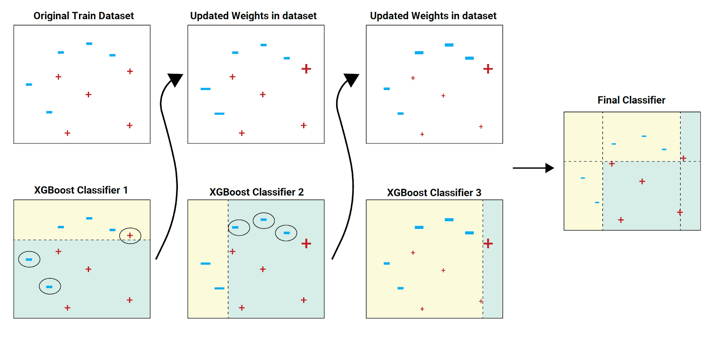


L'utilisation de XGBoost est motivée par ces faits.

### 1. Efficacité et rapidité

- **Entraînement rapide :** XGBoost est conçu pour l'efficacité. Il utilise le traitement parallèle et des techniques d'élagage des arbres qui réduisent considérablement le temps nécessaire pour entraîner des modèles complexes par rapport aux méthodes traditionnelles comme l'empilement.
- **Utilisation de la mémoire :** XGBoost optimise l'utilisation de la mémoire pendant les phases d'entraînement et de prédiction, ce qui le rend adapté aux grands ensembles de données.

### 2. Gestion des valeurs manquantes

- **Gestion automatique :** Contrairement à de nombreux autres algorithmes, y compris ceux souvent utilisés dans l'empilement, XGBoost peut gérer automatiquement les valeurs manquantes sans nécessiter de étapes de prétraitement explicites. Cette fonctionnalité simplifie la phase de préparation des données.

### 3. Régularisation

- **Régularisation intégrée :** XGBoost inclut des paramètres de régularisation qui empêchent le surapprentissage, conduisant à de meilleures capacités de généralisation. Bien que l'empilement puisse également obtenir une bonne généralisation grâce à une sélection minutieuse des apprenants de base, la gestion du surapprentissage nécessite plus d'intervention manuelle.

### 4. Scalabilité

- **Scalable aux grands ensembles de données :** XGBoost est hautement scalable et peut gérer efficacement de très grands ensembles de données. Sa scalabilité en fait un choix pratique pour les applications réelles où le volume de données est important.

### 5. Réglage des hyperparamètres

- **Recherche efficace d'hyperparamètres :** XGBoost fournit des outils efficaces pour le réglage des hyperparamètres, tels que la validation croisée intégrée. Cette fonctionnalité aide à trouver rapidement la configuration optimale du modèle, tandis que dans l'empilement, le réglage peut nécessiter des expérimentations plus poussées avec différentes combinaisons d'apprenants de base et de méta-apprenants.

### 6. Interprétabilité

- **Features importance :** XGBoost offre des informations sur l'importance des caractéristiques, ce qui peut être précieux pour comprendre les facteurs contribuant à l'identification des sites de phishing. Bien que l'empilement puisse également fournir l'importance des caractéristiques, l'interprétation de ces informations peut être plus difficile en raison de la complexité du modèle empilé.





In [13]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
import mlflow
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.base import BaseEstimator, TransformerMixin
import joblib

# Set MLflow Tracking URI
mlflow.set_tracking_uri('file:///C:/Users/fares/Documents/GitHub/test_technique/mlflow_data')

class ModelTrainer(BaseEstimator, TransformerMixin):
    """
    Trains an XGBoost model with optional SMOTE oversampling and feature importance logging. 
    """

    def __init__(self, use_smote=False, random_state=42, log_feature_importance=False):
        """Initializes the ModelTrainer."""
        self.use_smote = use_smote
        self.random_state = random_state
        self.best_xgb_clf = None
        self.log_feature_importance = log_feature_importance

    def _split_data(self, X, y):
        """Splits data into train and test sets."""
        return train_test_split(X, y, test_size=0.3, random_state=self.random_state, stratify=y)

    def _apply_smote(self, X_train, y_train):
        """Applies SMOTE oversampling."""
        smote = SMOTE(random_state=self.random_state, sampling_strategy="auto")
        return smote.fit_resample(X_train, y_train)

    def _train_model(self, X_train, y_train):
        """Trains the XGBoost model with GridSearchCV."""
        param_grid = {
            "max_depth": [5, 15, 25, 50],
            "learning_rate": [0.01, 0.1, 0.3, 0.5],
            "gamma": [0.1, 0.3, 0.5],
            "min_child_weight": [1, 3, 5],
        }
        xgb_clf = XGBClassifier(n_estimators=100, random_state=self.random_state)
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=self.random_state)
        grid_search = GridSearchCV(xgb_clf, param_grid, cv=cv, scoring="roc_auc", n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)
        return grid_search.best_estimator_, grid_search.best_params_

    def _evaluate_model(self, model, X_test, y_test):
        """Evaluates the model."""
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        classi_report = classification_report(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        return accuracy, precision, recall, f1, classi_report, conf_matrix

    def save_model(self, run_name):
        """Saves the trained model to a file."""
        if self.best_xgb_clf is None:
            raise ValueError("Model not fitted yet!")
        models_dir = "../notebooks/models/"
        os.makedirs(models_dir, exist_ok=True)
        model_path = os.path.join(models_dir, f"{run_name}_model.pkl")
        joblib.dump(self.best_xgb_clf, model_path)
        print(f"Model saved to: {model_path}")

    def fit(self, X, y=None, mlflow_run_name=None):
        """Fits the model to the data, logs metrics and artifacts to MLflow."""
        X_train, X_test, y_train, y_test = self._split_data(X.drop(columns=["label"]), X["label"])
        if self.use_smote:
            X_train, y_train = self._apply_smote(X_train, y_train)
        self.best_xgb_clf, best_params = self._train_model(X_train, y_train)

        experiment_name = "Phishing URLs Detection"
        mlflow.set_experiment(experiment_name)

        with mlflow.start_run(run_name=mlflow_run_name):
            mlflow.log_params(best_params)
            mlflow.xgboost.log_model(self.best_xgb_clf, "model")

            accuracy, precision, recall, f1, classi_report, conf_matrix = self._evaluate_model(
                self.best_xgb_clf, X_test, y_test
            )
            mlflow.log_metrics(
                {"accuracy": accuracy, "precision": precision, "recall": recall, "f1_score": f1}
            )
            
            classi_report_path = "../notebooks/artifacts/classification_report.txt"
            with open(classi_report_path, "w") as f:
                f.write(classi_report)
            mlflow.log_artifact(classi_report_path)

            if self.log_feature_importance:
                feature_importances = self.best_xgb_clf.feature_importances_
                importance_df = pd.DataFrame(
                    {"feature": X_train.columns, "importance": feature_importances}
                ).sort_values("importance", ascending=False)
                mlflow.log_dict(importance_df.to_dict(), "feature_importances.json")

                fig, ax = plt.subplots(figsize=(10, 6))
                sns.barplot(data=importance_df.head(20), x="importance", y="feature", ax=ax)
                ax.set_title("Top 20 Feature Importances")
                plt.tight_layout()
                fig_path = "../notebooks/artifacts/feature_importance.png"
                fig.savefig(fig_path)
                mlflow.log_artifact(fig_path)

            plt.figure(figsize=(8, 6))
            sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
            plt.title("Confusion Matrix")
            plt.xlabel("Predicted Label")
            plt.ylabel("True Label")
            fig_cm_path = "../notebooks/artifacts/confusion_matrix.png"
            plt.savefig(fig_cm_path)
            mlflow.log_artifact(fig_cm_path)

            run_name = mlflow.active_run().info.run_name

        self.save_model(run_name)
        return self

    def transform(self, X):
        """Predicts the target variable for new data."""
        if self.best_xgb_clf is None:
            raise ValueError("Model not fitted yet!")
        return self.best_xgb_clf.predict(X.drop(columns=["label"]))


Fitting 3 folds for each of 144 candidates, totalling 432 fits


Traceback (most recent call last):
  File "c:\Users\fares\Documents\GitHub\test_technique\.venv\lib\site-packages\mlflow\store\tracking\file_store.py", line 315, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "c:\Users\fares\Documents\GitHub\test_technique\.venv\lib\site-packages\mlflow\store\tracking\file_store.py", line 408, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "c:\Users\fares\Documents\GitHub\test_technique\.venv\lib\site-packages\mlflow\store\tracking\file_store.py", line 1339, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "c:\Users\fares\Documents\GitHub\test_technique\.venv\lib\site-packages\mlflow\store\tracking\file_store.py", line 1332, in _read_helper
    result = read_yaml(root, file_name)
  File "c:\Users\fares\Documents\GitHub\test_technique\.venv\lib\site-packages\mlflow\utils\file_utils.py", line 312, in read_yaml
    raise Missi

Model saved to: ../notebooks/models/XGBoost run 14_model.pkl


ModelTrainer(log_feature_importance=True, use_smote=True)

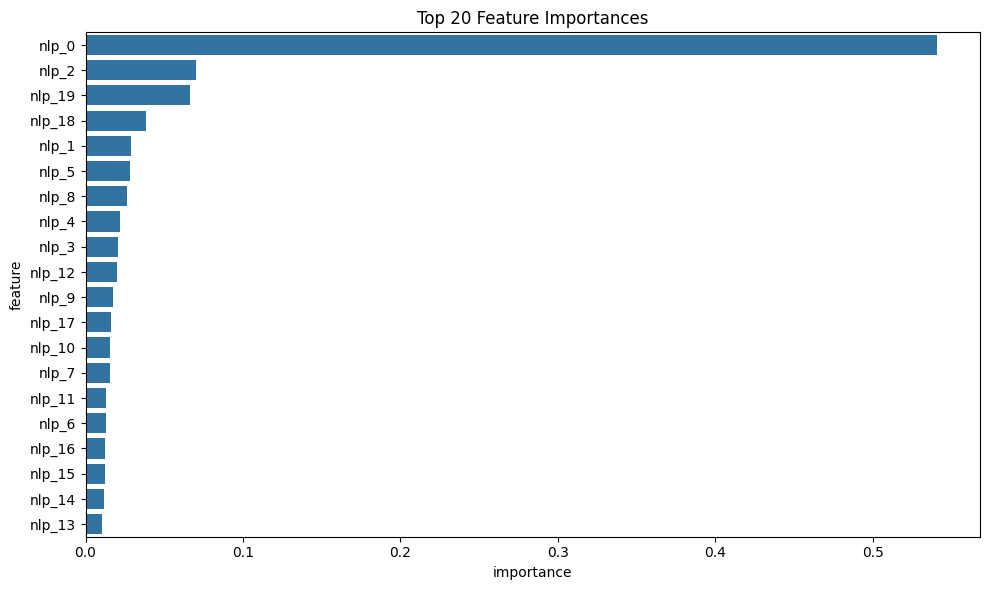

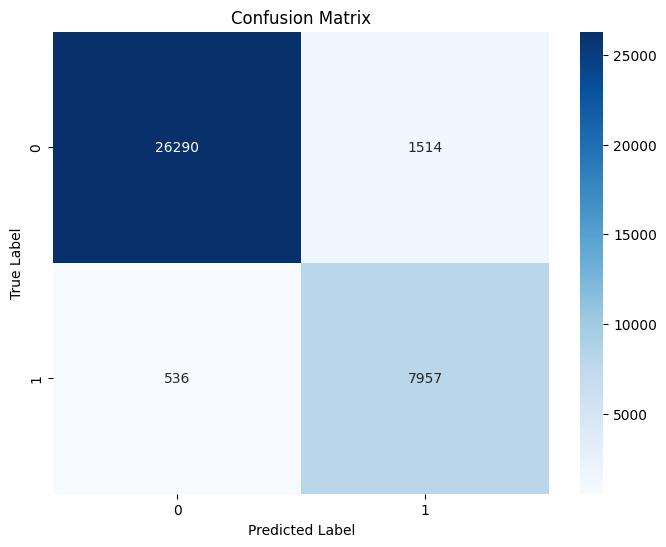

In [15]:
import pandas as pd

# Load datasets
df_combined = pd.read_csv('../notebooks/data/combined_features.csv')
df_custom = pd.read_csv('../notebooks/data/custom_features.csv')
df_tokenizer = pd.read_csv('../notebooks/data/tokenizer_features.csv')

model_trainer = ModelTrainer(use_smote=True, random_state=42, log_feature_importance=True)

# Train on combined features
X = df_tokenizer
y = df_tokenizer['label']
model_trainer.fit(X, y, mlflow_run_name="XGBoost run 14")

# Train on each set of features
# dataframes = {'combined': df_combined, 'custom': df_custom, 'tokenizer': df_tokenizer}

# for key, df in dataframes.items():
#     X = df
#     y = df['label']
#     model_trainer = ModelTrainer(use_smote=True, random_state=42, log_feature_importance=True)  # Create new instance for each dataset
#     model_trainer.fit(X, y, mlflow_run_name=f"XGBoost with features {key}")

c:\Users\fares\Documents\GitHub\test_technique\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
4055/4055 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.9175 - loss: 0.1955
Epoch 2/10
4055/4055 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9650 - loss: 0.0942
Epoch 3/10
4055/4055 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9702 - loss: 0.0818
Epoch 4/10
4055/4055 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9725 - loss: 0.0740
Epoch 5/10
4055/4055 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9728 - loss: 0.0741
Epoch 6/10
4055/4055 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9750 - loss: 0.0678
Epoch 7/10
4055/4055 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.9760 - loss: 0.0637
Epoch 8/10
4055/4055 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9779 - loss: 0.0611
Epoch 9/10
4055/4055 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - accuracy: 0.9762 - loss: 0.0630
Epoch 10/10
4055/4055 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.9783 - loss: 0.0578


Traceback (most recent call last):
  File "c:\Users\fares\Documents\GitHub\test_technique\.venv\lib\site-packages\mlflow\store\tracking\file_store.py", line 315, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "c:\Users\fares\Documents\GitHub\test_technique\.venv\lib\site-packages\mlflow\store\tracking\file_store.py", line 408, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "c:\Users\fares\Documents\GitHub\test_technique\.venv\lib\site-packages\mlflow\store\tracking\file_store.py", line 1339, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "c:\Users\fares\Documents\GitHub\test_technique\.venv\lib\site-packages\mlflow\store\tracking\file_store.py", line 1332, in _read_helper
    result = read_yaml(root, file_name)
  File "c:\Users\fares\Documents\GitHub\test_technique\.venv\lib\site-packages\mlflow\utils\file_utils.py", line 312, in read_yaml
    raise Missi

1135/1135 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


Model saved to: ../notebooks/models/TensorFlow CNN run 1_model.h5


ModelTrainer(use_smote=True)

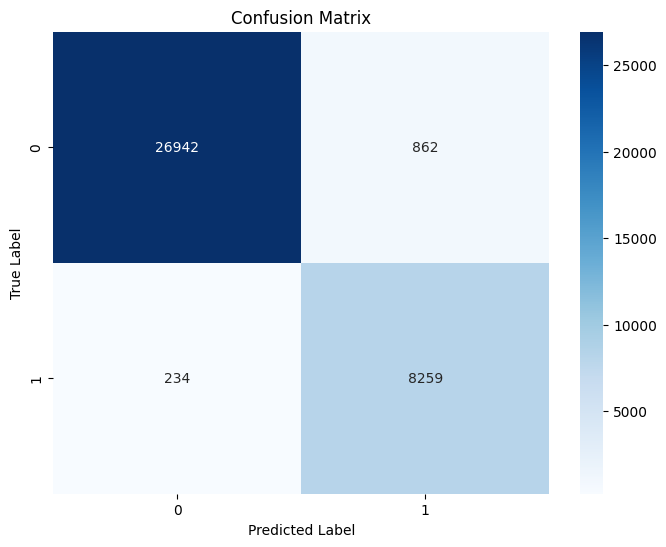

In [1]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.base import BaseEstimator, TransformerMixin
import joblib

# Set MLflow Tracking URI
mlflow.set_tracking_uri('file:///C:/Users/fares/Documents/GitHub/test_technique/mlflow_data')

class ModelTrainer(BaseEstimator, TransformerMixin):
    """
    Trains a TensorFlow CNN model with optional SMOTE oversampling and feature importance logging.
    """

    def __init__(self, use_smote=False, random_state=42, log_feature_importance=False, epochs=10):
        """Initializes the ModelTrainer."""
        self.use_smote = use_smote
        self.random_state = random_state
        self.best_model = None
        self.log_feature_importance = log_feature_importance
        self.epochs = epochs

    def _split_data(self, X, y):
        """Splits data into train and test sets."""
        return train_test_split(X, y, test_size=0.3, random_state=self.random_state, stratify=y)

    def _apply_smote(self, X_train, y_train):
        """Applies SMOTE oversampling."""
        smote = SMOTE(random_state=self.random_state, sampling_strategy="all")
        return smote.fit_resample(X_train, y_train)

    def _create_model(self, input_shape):
        """Creates a TensorFlow CNN model."""
        model = keras.Sequential(
            [
                keras.layers.Conv1D(64, kernel_size=3, activation="relu", input_shape=(input_shape, 1)),
                keras.layers.MaxPooling1D(pool_size=2),
                keras.layers.Conv1D(32, kernel_size=3, activation="relu"),
                keras.layers.MaxPooling1D(pool_size=2),
                keras.layers.Flatten(),
                keras.layers.Dense(128, activation="relu"),
                keras.layers.Dropout(0.5),
                keras.layers.Dense(64, activation="relu"),
                keras.layers.Dropout(0.5),
                keras.layers.Dense(1, activation="sigmoid"),
            ]
        )
        model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
        return model

    def _train_model(self, X_train, y_train):
        """Trains the TensorFlow model."""
        # Reshape input data to 3D for Conv1D: (samples, timesteps, features)
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        model = self._create_model(X_train.shape[1])
        model.fit(X_train, y_train, epochs=self.epochs, verbose=1)
        return model

    def _evaluate_model(self, model, X_test, y_test):
        """Evaluates the model."""
        # Reshape input data to 3D for Conv1D: (samples, timesteps, features)
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
        y_pred = (model.predict(X_test) > 0.5).astype("int32")
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        classi_report = classification_report(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        return accuracy, precision, recall, f1, classi_report, conf_matrix

    def save_model(self, run_name):
        """Saves the trained model to a file."""
        if self.best_model is None:
            raise ValueError("Model not fitted yet!")
        models_dir = "../notebooks/models/"
        os.makedirs(models_dir, exist_ok=True)
        model_path = os.path.join(models_dir, f"{run_name}_model.h5")
        self.best_model.save(model_path)
        print(f"Model saved to: {model_path}")

    def fit(self, X, y=None, mlflow_run_name=None):
        """Fits the model to the data, logs metrics and artifacts to MLflow."""
        X_train, X_test, y_train, y_test = self._split_data(X.drop(columns=["label"]), X["label"])
        if self.use_smote:
            X_train, y_train = self._apply_smote(X_train, y_train)
        
        # Scale features
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        self.best_model = self._train_model(X_train, y_train)

        experiment_name = "Phishing URLs Detection"
        mlflow.set_experiment(experiment_name)

        with mlflow.start_run(run_name=mlflow_run_name):
            # Log parameters (example - you can log more)
            mlflow.log_param("epochs", self.epochs)

            # Log model
            mlflow.tensorflow.log_model(self.best_model, "model")

            accuracy, precision, recall, f1, classi_report, conf_matrix = self._evaluate_model(
                self.best_model, X_test, y_test
            )
            mlflow.log_metrics(
                {"accuracy": accuracy, "precision": precision, "recall": recall, "f1_score": f1}
            )
            
            classi_report_path = "../notebooks/artifacts/classification_report.txt"
            with open(classi_report_path, "w") as f:
                f.write(classi_report)
            mlflow.log_artifact(classi_report_path)

            plt.figure(figsize=(8, 6))
            sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
            plt.title("Confusion Matrix")
            plt.xlabel("Predicted Label")
            plt.ylabel("True Label")
            fig_cm_path = "../notebooks/artifacts/confusion_matrix.png"
            plt.savefig(fig_cm_path)
            mlflow.log_artifact(fig_cm_path)

            run_name = mlflow.active_run().info.run_name

        self.save_model(run_name)
        return self

    def transform(self, X):
        """Predicts the target variable for new data."""
        if self.best_model is None:
            raise ValueError("Model not fitted yet!")
        # Reshape input data to 3D for Conv1D: (samples, timesteps, features)
        X = X.drop(columns=["label"]).values.reshape((X.shape[0], X.shape[1] - 1, 1))
        return (self.best_model.predict(X) > 0.5).astype("int32")

# Load datasets
df_combined = pd.read_csv('../notebooks/data/combined_features.csv')
df_custom = pd.read_csv('../notebooks/data/custom_features.csv')
df_tokenizer = pd.read_csv('../notebooks/data/tokenizer_features.csv')

model_trainer = ModelTrainer(use_smote=True, random_state=42, epochs=10)

# Train on combined features
X = df_combined
y = df_combined['label']
model_trainer.fit(X, y, mlflow_run_name="TensorFlow CNN run 1")


In [ ]:
test_set_X = test_set['domain']
test_set_y = test_set['label']

## Technique de Stacking 


Le stacking, est une technique d'ensemble qui entraîne plusieurs modèles de base, puis combine leurs prédictions à l'aide d'un méta-modèle. Cette approche tire parti de la diversité des modèles de base pour capturer différents aspects des motifs sous-jacents dans les données. Le méta-modèle apprend à combiner au mieux les prédictions des modèles de base pour produire le résultat final. Le stacking est flexible, permettant la combinaison de différents types de modèles, tels que les modèles linéaires, le desicion trees, gradient boosting etc,. offrant ainsi une approche plus complète de la prédiction.

### Avantages du Stacking

- **Diversité :** Le stacking bénéficie de la diversité des modèles de base, capturant potentiellement une gamme plus large de motifs dans les données.
- **Flexibilité :** Il permet l'intégration de divers types de modèles, permettant une approche sur mesure pour des problèmes spécifiques.
- **Performance :** Lorsqu'il est correctement mis en œuvre, le stacking peut conduire à une performance supérieure par rapport aux modèles individuels en réduisant à la fois le biais et la variance.

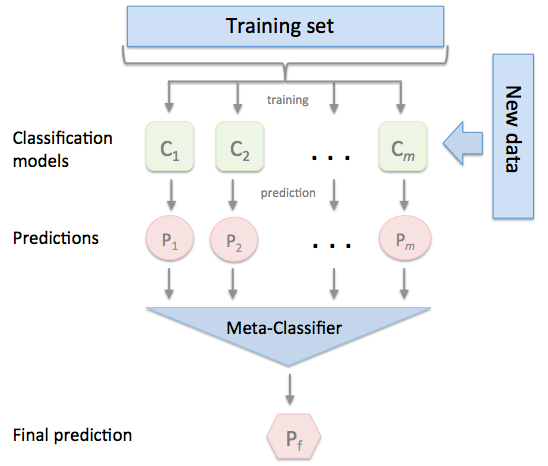





In [18]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
import mlflow
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.base import BaseEstimator, TransformerMixin
import joblib
import xgboost as xgb

mlflow.set_tracking_uri('file:///C:/Users/fares/Documents/GitHub/test_technique/mlflow_data')

class ModelTrainerStacking(BaseEstimator, TransformerMixin):
    """Trains a Stacking model with a specified final estimator."""

    def __init__(self, use_smote=False, random_state=42, final_estimator_C=1):
        """Initializes the ModelTrainerStacking class."""
        self.use_smote = use_smote
        self.random_state = random_state
        self.best_stack_clf = None
        self.final_estimator_C = final_estimator_C
        self.scaler = StandardScaler()

    def _split_data(self, X, y):
        """Splits data into train and test sets."""
        return train_test_split(X, y, test_size=0.3, random_state=self.random_state, stratify=y)

    def _apply_smote(self, X_train, y_train):
        """Applies SMOTE oversampling."""
        smote = SMOTE(random_state=self.random_state, sampling_strategy="auto")
        return smote.fit_resample(X_train, y_train)

    def _scale_data(self, X_train, X_test):
        """Scales the data using StandardScaler."""
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        return X_train_scaled, X_test_scaled

    def _train_model(self, X_train, y_train):
        """Trains the Stacking model."""
        base_learners = [
            ('lr', LogisticRegression()),
            ('dt', DecisionTreeClassifier()),
            ('nb', GaussianNB()),
            ('knn', KNeighborsClassifier()),
            ('rf', RandomForestClassifier()),
            ('gb', GradientBoostingClassifier())
        ]
        stack_clf = StackingClassifier(
            estimators=base_learners,
            final_estimator=xgb.XGBClassifier(n_estimators=100, random_state=self.random_state),
            cv=StratifiedKFold(n_splits=7, shuffle=True, random_state=self.random_state)
        )
        stack_clf.fit(X_train, y_train)
        return stack_clf, {}

    def _evaluate_model(self, model, X_test, y_test):
        """Evaluates the trained model."""
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        classi_report = classification_report(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        return accuracy, precision, recall, f1, classi_report, conf_matrix

    def save_model(self, run_name):
        """Saves the trained model to a file."""
        if self.best_stack_clf is None:
            raise ValueError("Model not fitted yet!")
        models_dir = "../notebooks//models/"
        os.makedirs(models_dir, exist_ok=True)
        model_path = os.path.join(models_dir, f"{run_name}_model.pkl")
        joblib.dump(self.best_stack_clf, model_path)
        print(f"Model saved to: {model_path}")

    def fit(self, X, y=None, mlflow_run_name=None):
        """Fits the model to the data, logs metrics and artifacts to MLflow."""
        X_train, X_test, y_train, y_test = self._split_data(X.drop(columns=["label"]), X["label"])
        if self.use_smote:
            X_train, y_train = self._apply_smote(X_train, y_train)
        
        X_train, X_test = self._scale_data(X_train, X_test)
        
        self.best_stack_clf, best_params = self._train_model(X_train, y_train)

        experiment_name = "Phishing URLs Detection"
        mlflow.set_experiment(experiment_name)

        with mlflow.start_run(run_name=mlflow_run_name):
            mlflow.log_params(best_params)
            mlflow.sklearn.log_model(self.best_stack_clf, "model")

            accuracy, precision, recall, f1, classi_report, conf_matrix = self._evaluate_model(
                self.best_stack_clf, X_test, y_test
            )
            mlflow.log_metrics(
                {"accuracy": accuracy, "precision": precision, "recall": recall, "f1_score": f1}
            )

            plt.figure(figsize=(8, 6))
            sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
            plt.title("Confusion Matrix")
            plt.xlabel("Predicted Label")
            plt.ylabel("True Label")
            cm_path = "../notebooks/artifacts/confusion_matrix.png"
            plt.savefig(cm_path, dpi=300, bbox_inches="tight")
            plt.close()

            classi_report_path = "../notebooks/artifacts/classification_report.txt"
            with open(classi_report_path, "w") as file:
                file.write(classi_report)

            mlflow.log_artifact(cm_path)
            mlflow.log_artifact(classi_report_path)
            run_name = mlflow.active_run().info.run_name

        self.save_model(run_name)
        return self

    def transform(self, X):
        """Predicts the target variable for new data."""
        if self.best_stack_clf is None:
            raise ValueError("Model not fitted yet!")
        X_scaled = self.scaler.transform(X.drop(columns=["label"]))
        return self.best_stack_clf.predict(X_scaled)

In [17]:
model_trainer = ModelTrainerStacking(use_smote=True, random_state=42)
model_trainer.fit(X, y, mlflow_run_name="Stacking version 3 with XGBoost as metalearner")

Traceback (most recent call last):
  File "c:\Users\fares\Documents\GitHub\test_technique\.venv\lib\site-packages\mlflow\store\tracking\file_store.py", line 315, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "c:\Users\fares\Documents\GitHub\test_technique\.venv\lib\site-packages\mlflow\store\tracking\file_store.py", line 408, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "c:\Users\fares\Documents\GitHub\test_technique\.venv\lib\site-packages\mlflow\store\tracking\file_store.py", line 1339, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "c:\Users\fares\Documents\GitHub\test_technique\.venv\lib\site-packages\mlflow\store\tracking\file_store.py", line 1332, in _read_helper
    result = read_yaml(root, file_name)
  File "c:\Users\fares\Documents\GitHub\test_technique\.venv\lib\site-packages\mlflow\utils\file_utils.py", line 312, in read_yaml
    raise Missi

Model saved to: ../models/Stacking version 3 with XGBoost as metalearner_model.pkl


ModelTrainerStacking(use_smote=True)

## **MLflow tracking results**

| Run ID                               | Run Name                                              | Accuracy | F1 Score | Precision | Recall |
|--------------------------------------|-------------------------------------------------------|----------|----------|-----------|--------|
| 6191c5384af844bc9a8460987878e5b9     | XGBoost + Combined Features + SMOTE (Kfold=3)         | 0.977    | 0.950    | 0.954     | 0.946  |
| afd366297aab46b099c0284e75f589d9     | XGBoost + Combined Features + SMOTE (Kfold=7)         | 0.977    | 0.950    | 0.954     | 0.946  |
| 3ac6b6694f7544beb06cbcc999512a32     | XGBoost + Combined Features + No SMOTE                | 0.977    | 0.952    | 0.952     | 0.951  |
| eb1139279ae74e4398636a90ddd5ed23     | XGBoost + Combined Features + Fine-Tuned Parameters   | 0.976    | 0.949    | 0.938     | 0.959  |
| 51d6d63cd9f34f37be95778167f7b1a1     | XGBoost + Combined Features                           | 0.975    | 0.948    | 0.936     | 0.960  |
| dbe7f58c456848e6840be44cacc79501     | Stacking + XGBoost as Metalearner                  | 0.973    | 0.942    | 0.941     | 0.943  |
| a7218d53d0a549718d5063fbbd04a7b1     | Stacking + Logistic Regression as metalearner + SMOTE Enabled     | 0.973    | 0.943    | 0.935     | 0.952  |
| b6e8f03ec4144f718892b03c449dff9e     | XGBoost + Custom Features (Duplicate)                 | 0.968    | 0.933    | 0.917     | 0.949  |
| dbe7f58c456848e6840be44cacc79501     | Stacking + Logistic Regression + No SMOTE          | 0.961    | 0.916    | 0.917     | 0.915  |
| dc5f23c4053944b8a7759757946b1429     | XGBoost + Tokenizer Features                          | 0.820    | 0.715    | 0.567     | 0.966  |

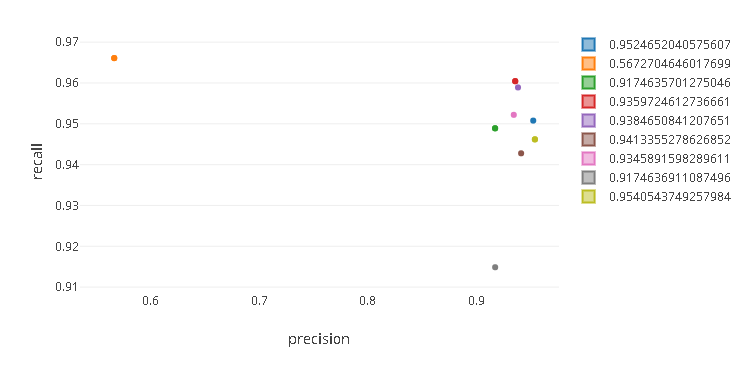

**Meilleur Modèle : XGBoost + Combined Features + SMOTE (Kfold=3) et XGBoost + Combined Features + SMOTE (Kfold=7)**

- **Accuracy** : 0.977
- **F1 Score** : 0.950
- **Precision** : 0.954
- **Recall** : 0.946

**Raisons :**
1. **Performance Globale** : Ces deux modèles ont les meilleures valeurs d'accuracy (0.977) parmi tous les modèles testés, ce qui indique qu'ils classifient correctement les instances dans la majorité des cas.
2. **Equilibre entre Précision et Rappel** : Les scores de précision et de rappel sont élevés et bien équilibrés, ce qui signifie que ces modèles sont capables de détecter les classes positives sans trop de faux positifs ni de faux négatifs.
3. **Utilisation de SMOTE** : L'utilisation de la technique SMOTE avec la validation croisée (K-fold) a probablement aidé légèrement à améliorer la performance en équilibrant les classes minoritaires. D'autres tests avec d'autres techniques d'augmentation de données pourraient être nécessaires.

**Pire Modèle : XGBoost + Tokenizer Features**

- **Accuracy** : 0.820
- **F1 Score** : 0.715
- **Precision** : 0.567
- **Recall** : 0.966

**Raisons :**
1. **Faible Précision** : Un score de précision de 0.567 est très bas, ce qui signifie que ce modèle a beaucoup de faux positifs. En d'autres termes, il identifie de nombreux exemples comme étant positifs alors qu'ils ne le sont pas.
2. **F1 Score Bas** : Avec un F1 score de 0.715, ce modèle est le moins performant en termes de balance entre précision et rappel. Un score F1 faible indique qu'il y a un compromis significatif entre les faux positifs et les faux négatifs.
3. **Caractéristiques des Tokenizers** : L'utilisation des caractéristiques à partir du tokenizer n'a peut-être pas été efficace dans la capture des caractéristiques pertinentes pour cette tâche spécifique.


LCes modèles utilisant xgboost combinant des caractéristiques avec la technique SMOTE et une validation croisée (Kfold=3 et Kfold=7) sont les plus performants en termes de précision, rappel et exactitude.Les modèles basés sur des tokenizers sont moins précis. Pour améliorer les modèles utilisant des tokenizers, il est conseillé d'examiner d'autres méthodes de prétraitement ou des représentations de données plus sophistiquées. La validation croisée et l'évaluation sur de nouvelles données sont importantes pour prévenir l'overfitting.


### **Meilleurs Paramètres pour XGBoost**

Les meilleurs paramètres pour les modèles XGBoost ayant les meilleures performances sont les suivants :

- **learning_rate** : 0.3
- **max_depth** : 7
- **n_estimators** : 300
- **subsample** : 1.0
- **reg_alpha** : 0.05
- **reg_lambda** : 0.1

En raison des capacités restreintes de mon ordinateur, le fine tuning des paramètres et la recherche exhaustive des paramètres ont été limitées.




### **Utiliser Stacking ou  XGBoost ?**

L'utilisation de **stacking** ou **d'XGBoost directement** dépend de plusieurs facteurs, principalement liés aux ressources disponibles et à la complexité des données (dimensionnalité et taille) :

1. **Stacking** :
   - **Avantages** : Peut potentiellement augmenter la performance en combinant les prédictions de plusieurs modèles (métamodèle). Bénéfique lorsque les modèles de base capturent différentes relations dans les données.
   - **Inconvénients** : Plus coûteux en termes de temps de calcul et de mémoire. Peut être moins efficace pour de très grands ensembles de Données en raison de la complexité et du temps d'entraînement plus long.

2. **XGBoost** :
   - **Avantages** : Moins de complexité, plus rapide à entraîner et à prédire. Très efficace pour une large gamme de problèmes de classification et de régression. Idéal pour les jeux de données de grande taille où les ressources de calcul sont limitées, facile à étudier la contribution des caractéristiques (feature importance).
   - **Inconvénients** : Peut ne pas capturer toutes les nuances que des techniques de stacking pourraient révéler.

Pour notre jeu de données de taille moyenne, le recours au stacking peut conduire à des améliorations de performance marginales. Néanmoins, pour des ensembles de données plus conséquents ou lorsque les ressources de calcul sont restreintes, l'adoption directe de XGBoost avec un réglage des hyperparamètres, comme ceux précédemment mentionnés, s'avère souvent être l'approche la plus efficace. Il convient systématiquement de prendre en considération l'équilibre entre la performance et les ressources disponibles afin de déterminer la technique la plus appropriée.

### Feature importance

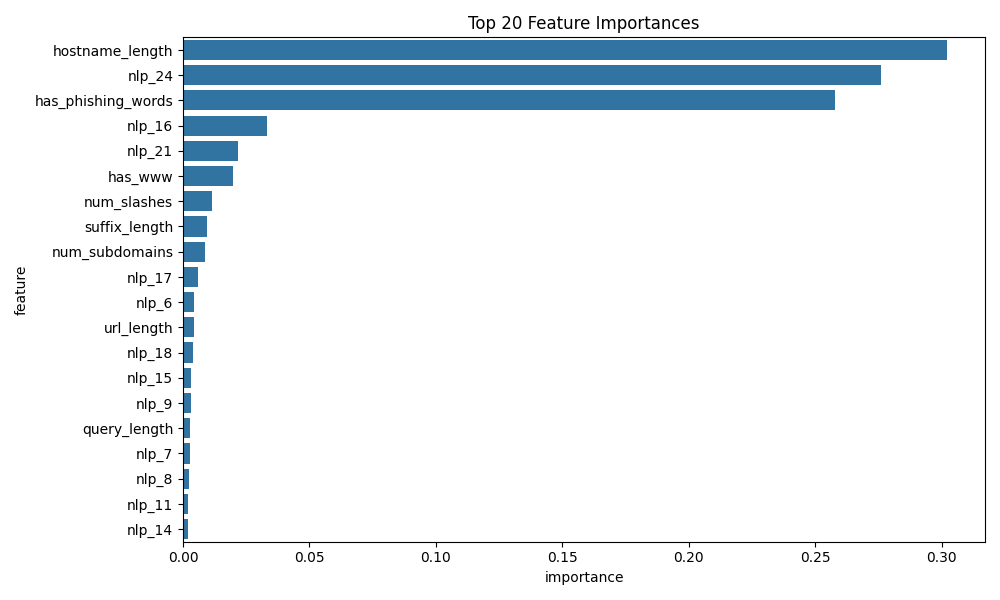

La présence de "www", la longueur du nom de domaine, la présence de mots liés au phishing et leur densité, et les schémas linguistiques subtils détectés par la tokenisation sont des caractéristiques cruciales pour prédire si une domaine est une domaine de phishing. Le modèle a appris que les domaines de phishing présentent souvent des noms de domaine plus longs, des termes associés au phishing, et des schémas linguistiques distinctifs. En combinant les caractéristiques extraites par un tokenizer avec des fonctionnalités NLP personnalisées, on peut développer un modèle plus robuste et efficace pour la détection des URLs de phishing.


### **Comment le modèle se comporte-t-il face à un nouveau jeu de données ?**

Le modèle a été testé sur des données comportant des domaines de sites de phishing et des sites légitimes qui proviennent de la référence suivante :


Marchal, S. (Créateur) (2014). PhishStorm - ensemble de données d'URLs de phishing et légitimes. Université Aalto. urlset(v.zip). 10.24342/f49465b2-c68a-4182-9171-075f0ed797d5

La taille du jeu de données est d'environ 96 000 domaines (50 % sont des domaines de phishing et 50 % sont légitimes).


In [7]:

import pandas as pd

test_set = pd.read_csv("../notebooks/data/test_set.csv", encoding='ISO-8859-1', on_bad_lines='skip')
print(test_set)



                                                  domain   ranking mld_res  \
0      nobell.it/70ffb52d079109dca5664cce6f317373782/...  10000000     1.0   
1      www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...  10000000     0.0   
2      serviciosbys.com/paypal.cgi.bin.get-into.herf....  10000000     0.0   
3      mail.printakid.com/www.online.americanexpress....  10000000     0.0   
4      thewhiskeydregs.com/wp-content/themes/widescre...  10000000     0.0   
...                                                  ...       ...     ...   
96000            xbox360.ign.com/objects/850/850402.html       339     1.0   
96001       games.teamxbox.com/xbox-360/1860/Dead-Space/     63029     1.0   
96002         www.gamespot.com/xbox360/action/deadspace/       753     1.0   
96003      en.wikipedia.org/wiki/Dead_Space_(video_game)         6     1.0   
96004          www.angelfire.com/goth/devilmaycrytonite/      2547     1.0   

      mld.ps_res  card_rem  ratio_Rrem  ratio_Arem  jaccard_RR 

C:\Users\fares\AppData\Local\Temp\ipykernel_44184\4269072942.py:3: DtypeWarning: Columns (1,2,3,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  test_set = pd.read_csv("../notebooks/data/test_set.csv", encoding='ISO-8859-1', on_bad_lines='skip')


In [8]:
test_set = test_set.dropna()
test_set['label'].value_counts()


label
0.0    48009
1.0    47904
Name: count, dtype: int64

In [9]:
test_set.isnull().sum()

domain           0
ranking          0
mld_res          0
mld.ps_res       0
card_rem         0
ratio_Rrem       0
ratio_Arem       0
jaccard_RR       0
jaccard_RA       0
jaccard_AR       0
jaccard_AA       0
jaccard_ARrd     0
jaccard_ARrem    0
label            0
dtype: int64

In [10]:
test_set_X = test_set['domain']
test_set_y = test_set['label']

In [2]:
import os
print(os.getcwd())


c:\Users\fares\Documents\GitHub\test_technique\notebooks


In [3]:
import sys
print(sys.path)


['c:\\Program Files\\Python310\\python310.zip', 'c:\\Program Files\\Python310\\DLLs', 'c:\\Program Files\\Python310\\lib', 'c:\\Program Files\\Python310', 'c:\\Users\\fares\\Documents\\GitHub\\test_technique\\.venv', '', 'c:\\Users\\fares\\Documents\\GitHub\\test_technique\\.venv\\lib\\site-packages', 'c:\\Users\\fares\\Documents\\GitHub\\test_technique\\.venv\\lib\\site-packages\\win32', 'c:\\Users\\fares\\Documents\\GitHub\\test_technique\\.venv\\lib\\site-packages\\win32\\lib', 'c:\\Users\\fares\\Documents\\GitHub\\test_technique\\.venv\\lib\\site-packages\\Pythonwin']


In [4]:
sys.path.append('C:/Users/fares/Documents/GitHub/test_technique')

In [11]:
from mlops.src.feature_engineering import FeatureEngineering
import joblib
import os
import joblib

# Absolute path to the notebooks directory
notebooks_dir = 'c:/Users/fares/Documents/GitHub/test_technique/notebooks'

# Absolute paths to the model and cv files
model_path = os.path.join(notebooks_dir, 'models/XGBoost run 14_model.pkl')
cv_path = os.path.join(notebooks_dir, 'models/cv.pkl')

# Load the model and cv
model = joblib.load(model_path)
cv = joblib.load(cv_path)

fe = FeatureEngineering(cv=cv)

all_predictions = []
for url in test_set_X:
    features_df = fe.feature_engineering_streamlit(url)
    prediction = model.predict(features_df)
    all_predictions.append(prediction[0])


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

accuracy = accuracy_score(test_set_y, all_predictions)
precision = precision_score(test_set_y, all_predictions)
recall = recall_score(test_set_y, all_predictions)
f1 = f1_score(test_set_y, all_predictions)
roc_auc = roc_auc_score(test_set_y, all_predictions)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")


Accuracy: 0.91
Precision: 0.98
Recall: 0.84
F1 Score: 0.91
ROC AUC Score: 0.91


## Conclusion

les scores de précision, de recall, de F1 et d'AUC-ROC sont encourageants. le modèle est capable de faire la différence entre les sites web légitimes et de phishing.  

La précision du modèle est supérieure au recall, ce qui suggère que le modèle est très bon pour confirmer l’absence de phishing, mais éprouve une légère difficulté à identifier l'ensemble des sites de phishing.

**Amélioration possible**

* **Ajuster les paramètres:**  ajuster les paramètres du modèle pour privilégier le recall, même si cela peut légèrement réduire la précision. 
* **Augmenter la quantité de données d'apprentissage:**  Utiliser une base de données d'apprentissage plus large et plus diversifiée pour aider le modèle à mieux généraliser et à identifier plus précisément les URL de phishing. 
* **Analyser les caractéristiques:**  Examiner les caractéristiques utilisées par le modèle et voir s'il est possible d'en ajouter ou d'en modifier pour améliorer son identification des URL de phishing. 

